2D MODEL: HS(DD2) neutron matter (with electrons):
https://compose.obspm.fr/eos/2

Inputs:
1. n_B [fm-3]: (0.1E-11 0.1E+02)
2. T [MeV]: (0.10000000E+00, 0.15848932E+03)
3. Y_q → Constant (0)

*   loss_fn = nn.MSELoss()
*   optimizer = optim.Adam(model.parameters(), lr, wd)
*   Random-search for hyperparameters = lr, hidden_sizes, batch, dropout

1. epochs = 1000
2. best params from random-search

! cut edge data on T set (avoid extreme extrapolation)


## PREVIOUS PREPARATON

### UPLOADING LIBRARIES AND DATA

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Load the data from drive
from google.colab import drive
drive.mount('/content/drive')
data_path = "/content/drive/My Drive/Colab Notebooks/data/"

# temperature and baryon number data
eos_t = np.loadtxt(data_path + 'eos.t', skiprows=2)  # 81 values
eos_nb = np.loadtxt(data_path + 'eos.nb', skiprows=2)  # 326 values
eos_yq = np.zeros(len(eos_t))  # Constant value of 0

# thermodynamic data
thermo_data = np.loadtxt(data_path + 'eos.thermo', skiprows=1)

# Extract indices and thermodynamic properties
indices = thermo_data[:, :3].astype(int)  # i_T, i_nb, i_Yq
i_t = indices[:, 0] - 1   # Convert to zero-based index
i_nb = indices[:, 1] - 1

q_data = thermo_data[:, 3:5]  # Q1 (pressure) and Q2 (entropy)

print("Indices shape:", indices.shape)
print("Q_values shape:", q_data.shape)

print("Max index for T:", np.max(indices[:, 0]))
print("Max index for nb:", np.max(indices[:, 1]))

Mounted at /content/drive
Indices shape: (26406, 3)
Q_values shape: (26406, 2)
Max index for T: 81
Max index for nb: 326


In [ ]:
# Ensure indices are valid, np.where() to get valid integer and not boolean
valid_indices = np.where((i_t >= 0) & (i_t < len(eos_t)) & (i_nb >= 0) & (i_nb < len(eos_nb)))[0]

T_values = np.log10(eos_t[i_t[valid_indices]])
nb_values = np.log10(eos_nb[i_nb[valid_indices]])
q_values = q_data[valid_indices]

In [ ]:
# Filter central 90%
T_q05, T_q95 = np.quantile(T_values, [0.05, 0.95])
nb_q05, nb_q95 = np.quantile(nb_values, [0.05, 0.95])
mask = (T_values >= T_q05) & (T_values <= T_q95) & \
       (nb_values >= nb_q05) & (nb_values <= nb_q95)

T_values = T_values[mask]
nb_values = nb_values[mask]
q_values = q_values[mask]

### PREPARATION OF DATA

Inputs shape: (21462, 2)
Outputs shape: (21462, 2)


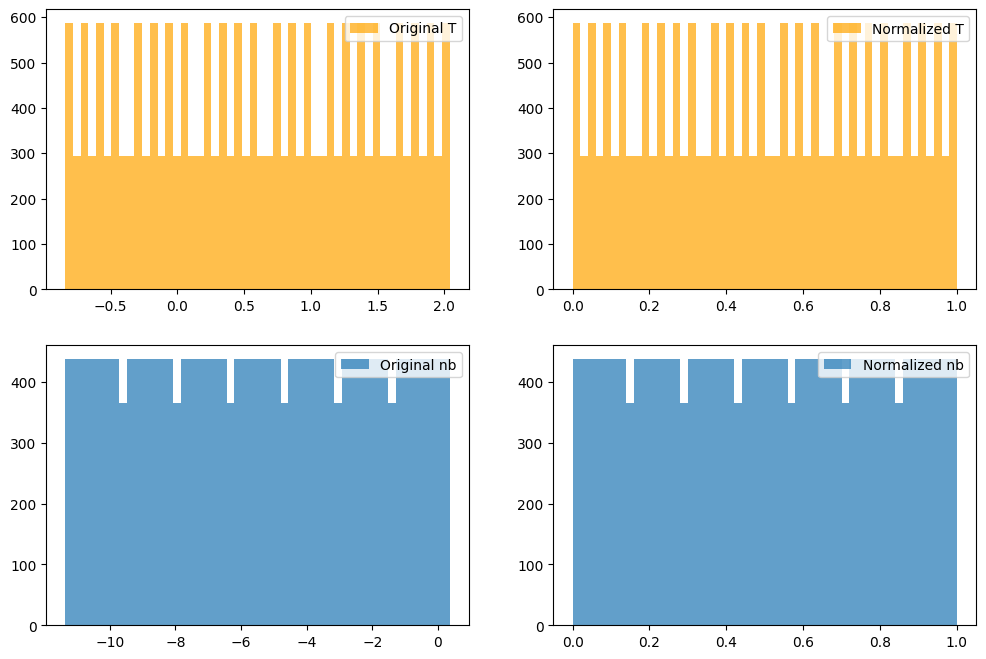

In [ ]:
# 1. Normalization
scaler_T = MinMaxScaler()
scaler_nb = MinMaxScaler()
T_scaled = scaler_T.fit_transform(T_values.reshape(-1, 1)).flatten()
nb_scaled = scaler_nb.fit_transform(nb_values.reshape(-1, 1)).flatten()
inputs = np.vstack((T_scaled, nb_scaled)).T

scaler_out_q1 = MinMaxScaler()
scaler_out_q2 = MinMaxScaler()
q1_scaled = scaler_out_q1.fit_transform(q_values[:, 0].reshape(-1, 1)).flatten()
q2_scaled = scaler_out_q2.fit_transform(q_values[:, 1].reshape(-1, 1)).flatten()
outputs = np.vstack((q1_scaled, q2_scaled)).T

print("Inputs shape:", inputs.shape)  # (number_of_samples, 2)
print("Outputs shape:", outputs.shape)

# Visualize normalization
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0, 0].hist(T_values, bins=50, alpha=0.7, label='Original T', color="orange")
axs[0, 1].hist(T_scaled, bins=50, alpha=0.7, label='Normalized T',  color="orange")
axs[1, 0].hist(nb_values, bins=50, alpha=0.7, label='Original nb')
axs[1, 1].hist(nb_scaled, bins=50, alpha=0.7, label='Normalized nb')
for ax in axs.flat:
    ax.legend()
plt.show()

In [ ]:
print(inputs[:400])

[[0.         0.        ]
 [0.         0.00341297]
 [0.         0.00682594]
 [0.         0.01023891]
 [0.         0.01365188]
 [0.         0.01706485]
 [0.         0.02047782]
 [0.         0.02389079]
 [0.         0.02730375]
 [0.         0.03071672]
 [0.         0.03412969]
 [0.         0.03754266]
 [0.         0.04095563]
 [0.         0.0443686 ]
 [0.         0.04778157]
 [0.         0.05119454]
 [0.         0.05460751]
 [0.         0.05802048]
 [0.         0.06143345]
 [0.         0.06484642]
 [0.         0.06825939]
 [0.         0.07167235]
 [0.         0.07508532]
 [0.         0.07849829]
 [0.         0.08191126]
 [0.         0.08532423]
 [0.         0.0887372 ]
 [0.         0.09215017]
 [0.         0.09556314]
 [0.         0.09897611]
 [0.         0.10238908]
 [0.         0.10580205]
 [0.         0.10921502]
 [0.         0.11262799]
 [0.         0.11604096]
 [0.         0.11945393]
 [0.         0.12286689]
 [0.         0.12627986]
 [0.         0.12969283]
 [0.         0.1331058 ]


In [ ]:
print(outputs[:100])

[[1.48099002e-12 1.47882998e-09]
 [1.35067168e-12 1.36431662e-09]
 [1.23181994e-12 1.25979498e-09]
 [1.12342583e-12 1.16438574e-09]
 [1.02456929e-12 1.07728727e-09]
 [9.34411015e-13 9.97768238e-10]
 [8.52185709e-13 9.25161740e-10]
 [7.77195325e-13 8.58859563e-10]
 [7.08803260e-13 7.98306987e-10]
 [6.46428992e-13 7.42998103e-10]
 [5.89542988e-13 6.92471531e-10]
 [5.37662301e-13 6.46306474e-10]
 [4.90346555e-13 6.04119169e-10]
 [4.47194110e-13 5.65559626e-10]
 [4.07838586e-13 5.30308624e-10]
 [3.71945946e-13 4.98075062e-10]
 [3.39211479e-13 4.68593429e-10]
 [3.09357254e-13 4.41621591e-10]
 [2.82129893e-13 4.16938699e-10]
 [2.57298246e-13 3.94343372e-10]
 [2.34651516e-13 3.73651916e-10]
 [2.13997450e-13 3.54696808e-10]
 [1.95160720e-13 3.37325270e-10]
 [1.77981417e-13 3.21397970e-10]
 [1.62313705e-13 3.06787834e-10]
 [1.48024585e-13 2.93378948e-10]
 [1.34992751e-13 2.81065631e-10]
 [1.23107577e-13 2.69751485e-10]
 [1.12268170e-13 2.59348580e-10]
 [1.02382516e-13 2.49776751e-10]
 [9.336668

In [ ]:
# 2. Split the data
# shuffling the dataset before splitting:
from sklearn.utils import shuffle
inputs, outputs = shuffle(inputs, outputs, random_state=42)

train_split = int(0.8 * len(inputs))  # 80% of data used for training set
validation_split = int(0.15 * len(inputs))  # 15% for validation

in_train, out_train = inputs[:train_split], outputs[:train_split]
in_val, out_val = inputs[train_split:train_split + validation_split], outputs[train_split:train_split + validation_split]
in_test, out_test = inputs[train_split + validation_split:], outputs[train_split + validation_split:] # 5% for test

len(in_train), len(out_train), len(in_val), len(out_val), len(in_test), len(out_test)

(17169, 17169, 3219, 3219, 1074, 1074)

In [ ]:
# 3. Convert data to PyTorch tensors
in_train_tensor = torch.FloatTensor(in_train)
out_train_tensor = torch.FloatTensor(out_train)
in_test_tensor = torch.FloatTensor(in_test)
out_test_tensor = torch.FloatTensor(out_test)
in_val_tensor = torch.FloatTensor(in_val)
out_val_tensor = torch.FloatTensor(out_val)

### DEFINE THE NN


In [ ]:
class Interpolation(nn.Module):
    def __init__(self, in_size, out_size, hidden_size, dropout, activation_fn):
        super(Interpolation, self).__init__()  # super() calls the constructor of the parent class to ensure proper initialization
        self.fc1 = nn.Linear(in_size, hidden_size)  # Input layer
        self.fc2 = nn.Linear(hidden_size, hidden_size*2)  # Hidden layer
        self.fc3 = nn.Linear(hidden_size*2, hidden_size)
        self.fc4 = nn.Linear(hidden_size, out_size)
        self.dropout = nn.Dropout(dropout)
        self.activation = activation_fn()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.activation(self.fc2(x))
        x = self.dropout(x)
        x = self.activation(self.fc3(x))
        x = self.fc4(x)  # No activation on the output -- regression
        return x

## MODEL SEARCH

In [ ]:
from sklearn.metrics import mean_squared_error
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from scipy.stats import randint
import random
import itertools
import time
import ast
import csv
import os

In [ ]:
epochs = 1000
patience = 100
batch_size = 64

input_size = 2
output_size = 2

params = {
    'hidden_size': 32,
    'dropout': 0.4,
    'lr': 1e-4,
    'activation_fn': nn.ReLU
}

model = Interpolation(input_size, output_size,
                            params['hidden_size'],
                            params['dropout'],
                            params['activation_fn'])

In [ ]:
def train_evaluate(model, lr, epochs, patience):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)  # Ensure the model is on the correct device

    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr)

    train_losses = []
    val_losses = []

    # Early stopping for bad hyperparameters combination
    patience_counter = 0
    best_val_loss = float('inf')

    start_time = time.time()

    # TRAINING AND VALIDATION
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        # Forward pass
        train_predictions = model(in_train_tensor.to(device))
        loss = loss_fn(predictions, out_train_tensor.to(device))

        # Backward pass
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        model.eval()
        with torch.no_grad():
            val_predictions = model(in_val_tensor.to(device))
            val_loss = loss_fn(val_predictions, out_val_tensor.to(device))

        val_loss_value = val_loss.item()
        val_losses.append(val_loss_value)

        # Early stopping logic
        if val_loss_value < best_val_loss:
            best_val_loss = val_loss_value
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch + 1} (patience {patience})")
                break

        if (epoch + 1) % 100 == 0 or epoch == 0:
            print(f"[Epoch {epoch + 1:4d}] Train Loss: {loss:.6f} | Val Loss: {val_loss:.6f}")

    # TESTING
    model.eval()
    with torch.no_grad():
        test_predictions = model(in_test_tensor.to(device))
        test_loss = loss_fn(test_predictions, out_test_tensor.to(device))

    print(f"Epoch: {epoch} | Train loss: {loss.item():.8f} | Test loss: {test_loss.item():.8f}")

    model_state = model.state_dict().copy()
    training_time = time.time() - start_time
    memory_usage_mb = torch.cuda.max_memory_allocated() / (1024**2) if device.type == 'cuda' else 0

    return train_predictions, val_predictions, test_predictions, train_losses, val_losses, model_state, training_time, memory_usage_mb

[Epoch    1] Train Loss: 0.010020 | Val Loss: 0.005907
[Epoch  100] Train Loss: 0.002156 | Val Loss: 0.001184
[Epoch  200] Train Loss: 0.001468 | Val Loss: 0.001080
[Epoch  300] Train Loss: 0.001123 | Val Loss: 0.000970
[Epoch  400] Train Loss: 0.000915 | Val Loss: 0.000873
[Epoch  500] Train Loss: 0.000768 | Val Loss: 0.000807
[Epoch  600] Train Loss: 0.000690 | Val Loss: 0.000759
[Epoch  700] Train Loss: 0.000637 | Val Loss: 0.000728
[Epoch  800] Train Loss: 0.000603 | Val Loss: 0.000714
[Epoch  900] Train Loss: 0.000588 | Val Loss: 0.000707
[Epoch 1000] Train Loss: 0.000571 | Val Loss: 0.000706
Epoch: 999 | Train loss: 0.00057146 | Test loss: 0.00113972


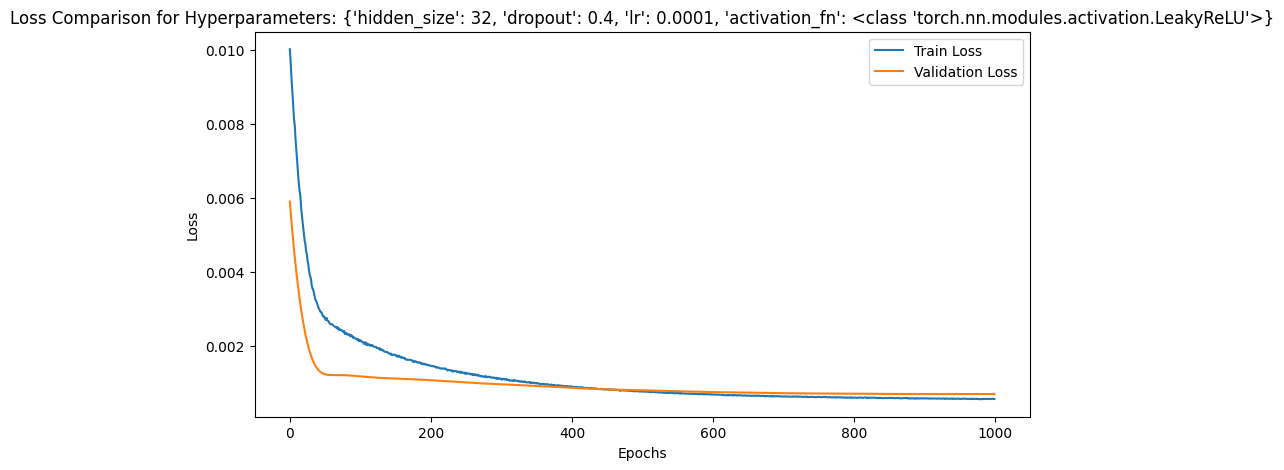

In [ ]:
train_pred, val_pred, test_pred, train_loss, val_loss, model_state, train_time, mem_usage = train_evaluate(
    model = model,
    lr = params['lr'],
    epochs = epochs,
    patience = patience
)
print(f"Total training time: {train_time}")
print(f"Total memory usage: {mem_usage}")

# Plotting the training vs validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Train Loss')
plt.plot(val:loss, label='Validation Loss')
plt.title('Loss Comparison for Hyperparameters: {}'.format(arams))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Saving the plot
hidden_str = str(params['hidden_size'])
activation_str = params['activation_fn'].__name__
lr_str = str(params['lr']).replace('.', '_')
drop_str = str(params['dropout']).replace('.', '_')
plotname = f"nobatch_plot_lr{lr_str}_act_{activation_str}_hid_{hidden_str}_drop_{drop_str}.png"
plt.savefig(f"/content/drive/My Drive/Colab Notebooks/random search/real_testing_model/final_results/{plotname}", dpi=300, bbox_inches='tight')

We've tracked the best validation loss both inside the training loop and outside on the hyperparameter combination loop:
1. Inside the Training Loop to implement early stopping.
  - Goal: Prevent wasting time training models that aren't improving.
  - Effect: Controls overfitting and saves training time.

2. Outside the Training Loop, using the final validation loss from each model to compare across different hyperparameter combinations.
  - Goal: Select the best model configuration.


### VISUALIZE RESULTS

In [ ]:
# Separate the predictions
train_pred_np = predictions.detach().numpy()
val_pred_np = val_predictions.detach().numpy()
test_pred_np = test_predictions.detach().numpy()

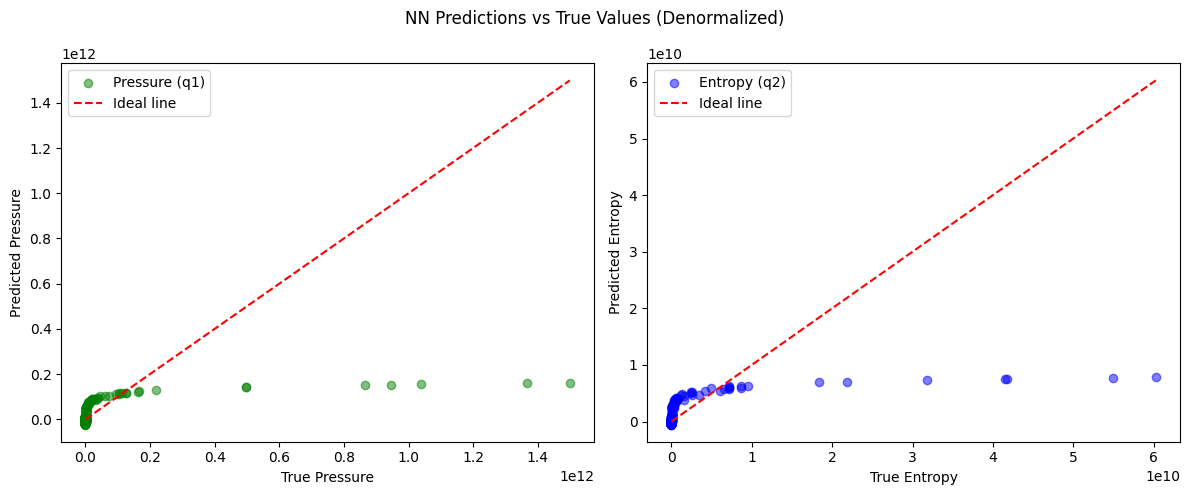

In [ ]:
#TESTING
# Denormalize each output dimension separately
true_P = scaler_out_q1.inverse_transform(out_test[:, 0].reshape(-1, 1)).flatten()
true_S = scaler_out_q2.inverse_transform(out_test[:, 1].reshape(-1, 1)).flatten()
pred_P = scaler_out_q1.inverse_transform(test_pred_np[:, 0].reshape(-1, 1)).flatten()
pred_S = scaler_out_q2.inverse_transform(test_pred_np[:, 1].reshape(-1, 1)).flatten()

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].scatter(true_P, pred_P, alpha=0.5, color='green', label='Pressure (q1)')
axs[1].scatter(true_S, pred_S, alpha=0.5, color='blue', label='Entropy (q2)')

axs[0].plot([min(true_P), max(true_P)], [min(true_P), max(true_P)], 'r--', label='Ideal line')
axs[1].plot([min(true_S), max(true_S)], [min(true_S), max(true_S)], 'r--', label='Ideal line')

axs[0].set_xlabel("True Pressure")
axs[0].set_ylabel("Predicted Pressure")
axs[1].set_xlabel("True Entropy")
axs[1].set_ylabel("Predicted Entropy")

axs[0].legend()
axs[1].legend()
plt.suptitle("NN Predictions vs True Values (Denormalized)")
plt.tight_layout()
plt.show()

> Points are closely aligned to the red dashed line, indicating good performance in predicting pressure values. Some deviation at higher true values highlights potential need for more data or fine-tuning in this range.

In [ ]:
# 3D Surface Plot for q1 (Pressure)
T_test = scaler_T.inverse_transform(in_test[:, 0].reshape(-1, 1)).flatten()
nb_test = scaler_nb.inverse_transform(in_test[:, 1].reshape(-1, 1)).flatten()

print(nb_test.shape), print(T_test.shape)
print(output_original[:, 0].shape), print(best_predictions_original[:, 0].shape)

print("Plotting predictions and original test data")
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(T_test, nb_test, output_original[:, 0], label='True q1', alpha=0.5)
ax.scatter(T_test, nb_test, best_predictions_original[:, 0], label='Interpolated q1', alpha=0.5)
ax.set_xlabel('Temperature')
ax.set_ylabel('Baryon Number')
ax.set_zlabel('Pressure')
ax.legend()

# 3D Surface Plot for q2 (Entropy)
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(T_test, nb_test, output_original[:, 1], label='True q2', alpha=0.5)
ax2.scatter(T_test, nb_test, best_predictions_original[:, 1], label='Interpolated q2', alpha=0.5)

ax2.set_xlabel('Temperature')
ax2.set_ylabel('Baryon Number')
ax2.set_zlabel('Entropy')
ax2.legend()

plt.show()

(1074,)
(1074,)


NameError: name 'output_original' is not defined

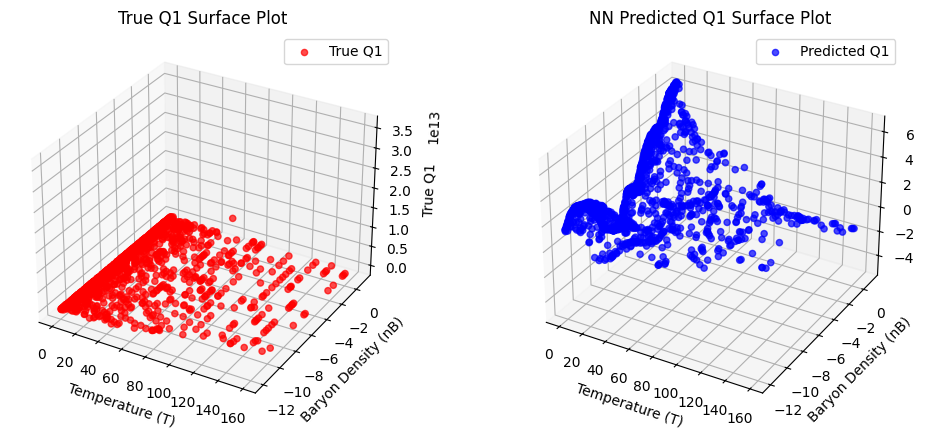

In [ ]:
# Create 3D figure
T_test = scaler_T.inverse_transform(in_test[:, 0].reshape(-1, 1)).flatten()
nb_test = scaler_nb.inverse_transform(in_test[:, 1].reshape(-1, 1)).flatten()

fig = plt.figure(figsize=(12,5))

# True Q1 surface plot
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(T_test, nb_test, output_original[:, 0], color='red', alpha=0.7, label="True Q1")
ax1.set_xlabel("Temperature (T)")
ax1.set_ylabel("Baryon Density (nB)")
ax1.set_zlabel("True Q1")
ax1.set_title("True Q1 Surface Plot")
ax1.legend()

# Predicted Q1 surface plot
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(T_test, nb_test, predictions_original[:, 0], color='blue', alpha=0.7, label="Predicted Q1")
ax2.set_xlabel("Temperature (T)")
ax2.set_ylabel("Baryon Density (nB)")
ax2.set_zlabel("Predicted Q1")
ax2.set_title("NN Predicted Q1 Surface Plot")
ax2.legend()

plt.show()

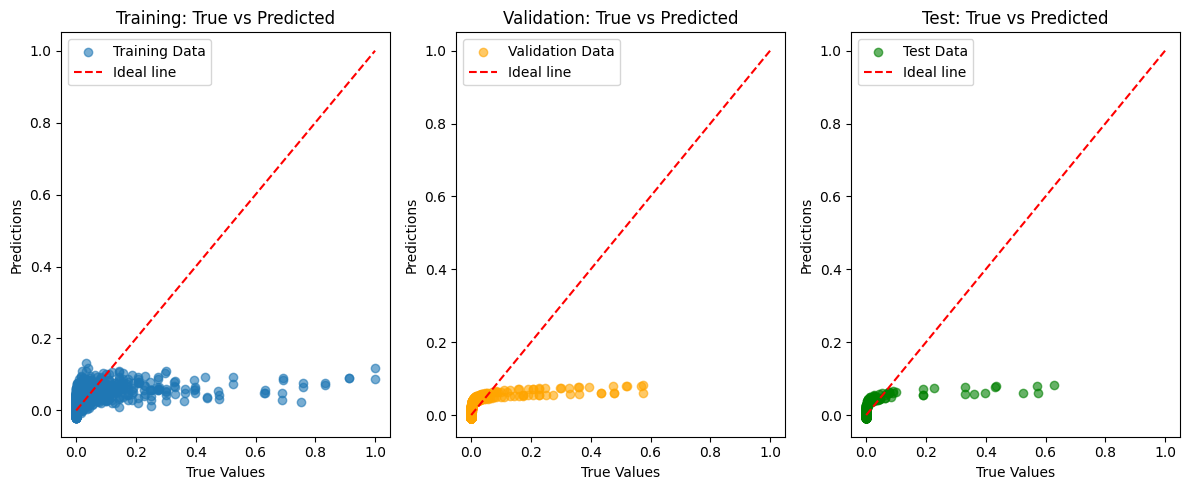

<Figure size 640x480 with 0 Axes>

In [ ]:
# Scatter Plot for actual vs predicted
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.scatter(out_train, train_pred_np, alpha=0.6, label='Training Data')
plt.plot([0, 1], [0, 1], 'r--', label='Ideal line')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Training: True vs Predicted')
plt.legend()

plt.subplot(1, 3, 2)
plt.scatter(out_val, val_pred_np, alpha=0.6, label='Validation Data', color='orange')
plt.plot([0, 1], [0, 1], 'r--', label='Ideal line')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Validation: True vs Predicted')
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(out_test, test_pred_np, alpha=0.6, label='Test Data', color='green')
plt.plot([0, 1], [0, 1], 'r--', label='Ideal line')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Test: True vs Predicted')
plt.legend()

plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()

Contour plots are a great way to visualize how a 2D model behaves across its input features (T and nb) and the predicted outputs (Q1, Q2).


In [ ]:
# Create a grid of temperature and baryon number
T_range = np.linspace(in_train_tensor[:, 0].min(), in_train_tensor[:, 0].max(), 100)
nb_range = np.linspace(in_train_tensor[:, 1].min(), in_train_tensor[:, 1].max(), 100)

# Create a meshgrid for the inputs
T_grid, nb_grid = np.meshgrid(T_range, nb_range)
input_grid = np.vstack([T_grid.ravel(), nb_grid.ravel()]).T

# Convert grid into tensor for the model to predict
input_grid_tensor = torch.tensor(input_grid, dtype=torch.float32)

# Get predictions from the model
best_model.eval()
with torch.no_grad():
    predictions_grid = best_model(input_grid_tensor).cpu().numpy()

# Reshape to match the grid shape
predictions_grid = predictions_grid.reshape(T_grid.shape[0], T_grid.shape[1], -1)
true_values_grid = np.append(true_P_grid, true_S_grid)

# Plot the contour for predictions vs true values for Q1
plt.figure(figsize=(8, 6))

cp = plt.contourf(T_grid, nb_grid, predictions_grid[:, :, 0], 20, cmap='coolwarm')
plt.colorbar(cp, label="Predicted Q1")

cp_true = plt.contour(T_grid, nb_grid, true_values_grid[:, :, 0], 20, colors='black', linestyles='dashed')
plt.clabel(cp_true, inline=True, fontsize=8)

plt.xlabel('Temperature (T)')
plt.ylabel('Baryon Number Density (n_b)')
plt.title('Contour Plot of Q1: Predicted vs True')

plt.tight_layout()
plt.show()

# Plot the contour for predictions vs true values for Q2
plt.figure(figsize=(8, 6))

cp = plt.contourf(T_grid, nb_grid, predictions_grid[:, :, 1], 20, cmap='coolwarm')
plt.colorbar(cp, label="Predicted Q1")

cp_true = plt.contour(T_grid, nb_grid, true_values_grid[:, :, 1], 20, colors='black', linestyles='dashed')
plt.clabel(cp_true, inline=True, fontsize=8)

plt.xlabel('Temperature (T)')
plt.ylabel('Baryon Number Density (n_b)')
plt.title('Contour Plot of Q2: Predicted vs True')

plt.tight_layout()
plt.show()

### MODEL'S STATISTICS

In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import Dense

predictions_np = predictions.detach().cpu().numpy()

# Calculate metrics for TRAINING
mse_train_q1 = np.mean((out_train[:, 0] - predictions_np[:, 0]) ** 2)
mae_train_q1 = mean_absolute_error(out_train[:, 0], predictions_np[:, 0])
r2_train_q1 = r2_score(out_train[:, 0], predictions_np[:, 0])

mse_train_q2 = np.mean((out_train[:, 1] - predictions_np[:, 1]) ** 2)
mae_train_q2 = mean_absolute_error(out_train[:, 1], predictions_np[:, 1])
r2_train_q2 = r2_score(out_train[:, 1], predictions_np[:, 1])

# Print metrics for q1 and q2
print('Training statistics:')
results = {
    'Metric': ['Mean Squared Error (MSE)', 'Mean Absolute Error (MAE)', 'R-squared (R2)'],
    'Q1 (Pressure)': [mse_train_q1, mae_train_q1, r2_train_q1],
    'Q2 (Entropy)': [mse_train_q2, mae_train_q2, r2_train_q2]
}
results0_df = pd.DataFrame(results)
print(results0_df)

Training statistics:
                      Metric  Q1 (Pressure)  Q2 (Entropy)
0   Mean Squared Error (MSE)       0.008695      0.007658
1  Mean Absolute Error (MAE)       0.066363      0.062458
2             R-squared (R2)     -23.135292    -17.024170


* Q1 (Pressure):
1. MSE: is a very small, indicating that the model's predictions for pressure are quite close to the true values.
2. MAE: on average, the model's predictions for pressure are off by 0.00087, which is relatively low.
3. R²: a value of 0.899 suggests that the model explains about 89.9% of the variance in the pressure data, which is a strong result.

* For Q2 (Entropy):
1. MSE: similar to q1, the model's predictions for entropy have a very low MSE, indicating accurate predictions.
2. MAE: the average error for entropy is slightly higher than for pressure but still relatively low.
3. R²: the model explains 89.3% of the variance in entropy, which is similarly strong.

Overall Interpretation:
The model shows high accuracy in predicting both pressure and entropy, as indicated by the high R² values and low MSE/MAE. Given that the R² values are near 0.9, it seems like the model is doing a good job of capturing the underlying patterns in the data.

In [ ]:
# Calculate metrics for VALIDATION
val_predictions_np = val_predictions.detach().cpu().numpy()

mse_val_q1 = np.mean((out_val[:, 0] - val_predictions_np[:, 0]) ** 2)
mae_val_q1 = mean_absolute_error(out_val[:, 0], val_predictions_np[:, 0])
r2_val_q1 = r2_score(out_val[:, 0], val_predictions_np[:, 0])

mse_val_q2 = np.mean((out_val[:, 1] - val_predictions_np[:, 1]) ** 2)
mae_val_q2 = mean_absolute_error(out_val[:, 1], val_predictions_np[:, 1])
r2_val_q2 = r2_score(out_val[:, 1], val_predictions_np[:, 1])

# Print metrics for q1 and q2
print('Validation statistics:')
results_val = {
    'Metric': ['Mean Squared Error (MSE)', 'Mean Absolute Error (MAE)', 'R-squared (R2)'],
    'Q1 (Pressure)': [mse_val_q1, mae_val_q1, r2_val_q1],
    'Q2 (Entropy)': [mse_val_q2, mae_val_q2, r2_val_q2]
}
results0_val_df = pd.DataFrame(results_val)
print(results0_val_df)

Validation statistics:
                      Metric  Q1 (Pressure)  Q2 (Entropy)
0   Mean Squared Error (MSE)       0.002827      0.001963
1  Mean Absolute Error (MAE)       0.038923      0.026687
2             R-squared (R2)      -3.430198     -1.764695


The model performs excellently on the validation data with very small prediction errors (MSE, MAE) and high R² values (around 92% for pressure and 92% for entropy).
These metrics confirm that the model generalizes well to unseen data.

**CONCLUSIONS**
* Performance: The model is showing good predictive capabilities, especially for q1 (Pressure).
* Overfitting: Consider implementing strategies to mitigate overfitting, such as:
1. Early stopping
2. Experimenting with different architectures or dropout rates
3. Data augmentation or more training data
4. Investigate the influence of hyperparameters (like learning rate and hidden layer sizes) on model performance through systematic tuning.

## FINAL INTERPOLATION CHECK


Now that i've found a model that performs as hoped, the whole goal of my interpolation nn is interpolating from a tabulated EoS of Neutron Stars, where the known x variables are temperature (T) and baryon number (n_b) and the y variables are pressure (P) and Entropy (S).

I do know the values of both the x and y variables because i take them from given tabulated EoS in compose archive. However, i need to prove that my interpolating algorithm is good, this means i should stick to a small region of my range and do an interpolation, taking lets say x_1 and x_3 that i do know and interpolating y_2 for x_2 that even if i also know both values i write a code as if i didn't, in order to prove if it interpolates well.

1. Select Known Points:
Let’s assume we have points (x_1) (T1, n1) and (x_3) (T3, n3) that we know, where (x_2) will be the intermediate point.
Define (x_2) (T2, n2) within the range of the known points.

2. Interpolation Procedure
Treat the prediction for (x_2) (T2, n2) as an unknown during your actual interpolation process.
During this phase, we use the model to predict (P_2) and (S_2).

3. Evaluation
Calculate the difference between predicted (P_2) and (S_2) from the model and the exact known values from the tabulated EoS.
Metrics like Mean Absolute Error (MAE) or Mean Squared Error (MSE) to quantify how close the interpolated values are to the actual known values.

### NEURAL NETWORK INTERPOLATION

In [ ]:
# Interpolating
with torch.no_grad():
    x_2 = torch.tensor([[T2, n2]], dtype=torch.float32)
    prediction = final_model(x_2)

# Validation
actual_P2, actual_S2 = get_actual_values(T2, n2)  # replace with your method to get actual values

error_P = abs(prediction[0][0].item() - actual_P2)
error_S = abs(prediction[0][1].item() - actual_S2)

print(f"Predicted P2: {prediction[0][0].item()}, Actual P2: {actual_P2}, Error: {error_P}")
print(f"Predicted S2: {prediction[0][1].item()}, Actual S2: {actual_S2}, Error: {error_S}")

### CLASSICAL INTERPOLATION

Measure and compare time performance

In [ ]:
from scipy.interpolate import griddata

# Create interpolation function from training data
train_points = in_train_tensor.numpy()
train_values = out_train_tensor.numpy()

def classical_interp(query_points):
    return griddata(train_points, train_values, query_points, method='linear')

# Measure interpolation time
query = in_test_tensor.numpy()
start_time = time.time()
_ = classical_interp(query)
duration = time.time() - start_time
print(f"Classical interpolation time for {len(query)} samples: {duration:.4f} s")
print(f"Avg per sample: {(duration / len(query)) * 1e6:.2f} µs")

In [ ]:
import matplotlib.pyplot as plt

methods = ['NN (Batch)', 'Classical']
times = [nn_duration / len(in_test_tensor) * 1e6, interp_duration / len(query) * 1e6]  # in µs

plt.bar(methods, times, color=['skyblue', 'orange'])
plt.ylabel("Avg Inference Time per Sample (µs)")
plt.title("NN vs Classical Interpolation Speed")
plt.grid(axis='y')
plt.show()
